# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.30 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.23999999463558197


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## Let's coding

In this project, I applied the DDPG algorithm to train an agent. I adapt the code from the exercise ddpg-pendulum [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum) and ShangtongZhang's github repo [here](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction) to this project by making as few modifications as possible.

- Using Elu activation instead of Relu activation
- Using bigger Actor-Critic networks
- Using Gradient Clipping to prevent gradient vanishing/exploring

In [7]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import copy

In [8]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class ActorNetwork(nn.Module):
    """Actor Model."""

    def __init__(self, state_size, action_size, seed, fc1_dims = 512, fc2_dims = 512):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_dims (int): Number of nodes in first hidden layer
            fc2_dims (int): Number of nodes in second hidden layer

        """
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.bn1 = nn.BatchNorm1d(fc1_dims)
        self.bn2 = nn.BatchNorm1d(fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, action_size)        
         
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)


    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)
            
        x =  F.elu(self.fc1(state))
        x =  self.bn1(x)
        
        x =  F.elu(self.fc2(x))
        x =  self.bn2(x)
        return F.tanh(self.fc3(x))
    
    
    
class CriticNetwork(nn.Module):
    """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

    def __init__(self, state_size, action_size, seed, fc1_dims = 512, fc2_dims = 512):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_dims (int): Number of nodes in first hidden layer
            fc2_dims (int): Number of nodes in second hidden layer

        """
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dims)
        self.bn1 = nn.BatchNorm1d(fc1_dims)
        self.fc2 = nn.Linear(action_size+ fc1_dims, 2*fc2_dims)
        self.fc3  = nn.Linear(2*fc2_dims , fc2_dims)  
        self.fc4 =  nn.Linear(fc2_dims , 1)
              
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(self.device)        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3.weight.data.uniform_(-4e-3, 4e-3)


    def forward(self, state, action):
        """Build a network that maps state -> action values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)
            
        x = F.elu(self.fc1(state))
        state_value = self.bn1(x)
       
        state_action_value = F.elu(torch.cat((state_value, action), dim=1))
        state_action_value = F.elu(self.fc2(state_action_value))
        state_action_value = F.elu(self.fc3(state_action_value))
        
        return self.fc4(state_action_value)

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, config, random_seed = 0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = config["buffer_size"]
        self.batch_size  = config["batch_size"]
        self.tau = config["tau"]
        self.gamma = config["gamma"]
        self.lr_critic = config["lr_critic"]
        self.lr_actor = config["lr_actor"]
        self.update   =  config["update"]
        self.t_step = 0
        
        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size,self.batch_size, random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local  = ActorNetwork(state_size, action_size, random_seed)
        self.actor_target = ActorNetwork(state_size, action_size, random_seed)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = self.lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = CriticNetwork(state_size, action_size, random_seed)
        self.critic_target = CriticNetwork(state_size, action_size, random_seed)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = self.lr_critic)
        
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn, if enough samples are available in memory        
        self.t_step = (self.t_step + 1) % self.update
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            for _ in range(4):
                if len(self.memory) > self.batch_size:
                    experiences = self.memory.sample()
                    self.learn(experiences)

    def choose_action(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.actor_local.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    
    
    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        states  = torch.tensor(states, dtype = torch.float).to(self.actor_local.device)
        rewards = torch.tensor(rewards,dtype = torch.float ).to(self.actor_local.device)
        dones   = torch.tensor(dones,  dtype = torch.float).to(self.actor_local.device)
        actions = torch.tensor(actions, dtype = torch.float).to(self.actor_local.device)
        next_states = torch.tensor(next_states, dtype = torch.float).to(self.actor_local.device)

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target.forward(next_states)
        Q_targets_next = self.critic_target.forward(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local.forward(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1.0)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local.forward(states)
        actor_loss = - self.critic_local.forward(states, actions_pred)
        actor_loss = torch.mean(actor_loss)
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1.0)
        self.actor_optimizer.step()
        
        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target) 
    def reset(self):
        self.noise.reset()
    
    def soft_update(self, local_model, target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.05):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [11]:
def plot_learning_curve(x, scores, figure_file):
     
    running_avg = np.empty(len(scores))
    
    for t in range(len(scores)):
        running_avg [t] = np.mean(scores[max(0, t-100):(t+1)])        
        
    plt.plot(x, running_avg)
    plt.title("running avg of previous 100 scores")
    plt.savefig(figure_file)

Episode 10	Average Score: 1.41	 score_actual: 0.50
Episode 20	Average Score: 0.85	 score_actual: 1.25
Episode 30	Average Score: 1.11	 score_actual: 2.37
Episode 40	Average Score: 1.48	 score_actual: 1.27
Episode 50	Average Score: 1.97	 score_actual: 4.20
Episode 60	Average Score: 3.11	 score_actual: 14.15
Episode 70	Average Score: 4.92	 score_actual: 24.97
Episode 80	Average Score: 7.65	 score_actual: 21.64
Episode 90	Average Score: 10.78	 score_actual: 39.05
Episode 100	Average Score: 12.63	 score_actual: 39.40
Episode 110	Average Score: 16.02	 score_actual: 31.64
Episode 120	Average Score: 19.71	 score_actual: 39.06
Episode 130	Average Score: 23.39	 score_actual: 35.24
Episode 140	Average Score: 26.86	 score_actual: 38.00
Episode 150	Average Score: 30.16	 score_actual: 36.17
Episode 160	Average Score: 33.16	 score_actual: 39.10
Episode 170	Average Score: 35.29	 score_actual: 38.56
Episode 180	Average Score: 36.04	 score_actual: 33.44
Episode 190	Average Score: 36.13	 score_actual: 39

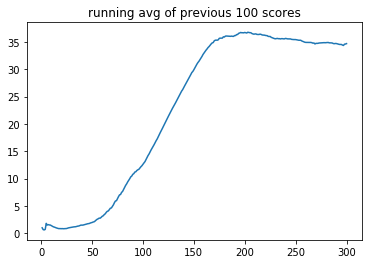

In [12]:
config = {"buffer_size": 1000000,  # replay buffer size
          "batch_size" : 128,        # minibatch size
          "gamma" : 0.99,            # discount factor
          "tau" : 1e-3,              # for soft update of target parameters
          "lr_actor" : 3e-4,         # learning rate of the actor 
          "lr_critic": 4e-4,        # learning rate of the critic
          "update": 4               # Update times of critic/actor in each trajectory
             }
n_games = 300  # number of trajectories
max_t = 1000000 # Max timestep in a trajectory

scores, eps_history = [], []

state_size = 33
action_size= 4
agent = Agent(state_size, action_size, config, random_seed=2342)
best_scores = 0
scores_deque = deque(maxlen= 100)

for i in range(1, n_games+1):
    env_info = env.reset(train_mode=True)[brain_name]    # reset the environment
    state = env_info.vector_observations[0]
    score = 0
    done = False
    # Reset noise
    agent.reset()
    
    for t in range(max_t):
        action = agent.choose_action(state)

        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]

        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        
        if done:
            break

    scores.append(score)              # save most recent score
    scores_deque.append(score)   
    avg_score = np.mean(scores_deque)    
    print('\rEpisode {}\tAverage Score: {:.2f}\t score_actual: {:.2f}'.format(i, avg_score, score), end="")
    
    if avg_score > best_scores:
        best_scores = avg_score
        # Save model
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

    if i % 10 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, avg_score))

x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, figure_file = "fig.png")    



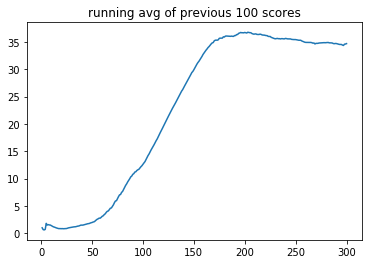

In [13]:
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, figure_file = "fig.png")   